In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_columns', None)


# Stock Price Prediction 

Giới thiệu Project: ###


## Dataset

Giá chứng khoán FPT 

In [27]:
data = pd.read_csv('../dataset/excel_fpt.csv')

In [28]:
data.tail()

,<Ticker>,<DTYYYYMMDD>,<Open>,<High>,<Low>,<Close>,<Volume>
3485,FPT,20061219,27.4356,27.4356,27.4356,27.4356,137520
3486,FPT,20061218,26.1371,26.1371,26.1371,26.1372,215790
3487,FPT,20061215,24.8952,24.8952,24.8952,24.8952,265300
3488,FPT,20061214,23.7097,23.7097,23.7097,23.7097,280710
3489,FPT,20061213,22.5807,22.5807,22.5807,22.5807,83530


In [29]:
data.head()

,<Ticker>,<DTYYYYMMDD>,<Open>,<High>,<Low>,<Close>,<Volume>
0,FPT,20201216,57.2,57.5,57.0,57.1,1995530
1,FPT,20201215,57.5,57.6,56.6,56.7,2666900
2,FPT,20201214,57.0,58.0,56.9,57.2,1443760
3,FPT,20201211,56.6,57.0,56.3,57.0,1750270
4,FPT,20201210,57.0,57.7,56.5,56.5,2112490


In [30]:
data.shape

(3490, 7)

- Giá tham chiếu: giá Close ngày hôm trước
- Giá Open: giá chốt lệnh lần đầu tiên trong ngày
- Giá High: giá khớp lệnh cao nhất trong ngày
- Giá Low: giá khớp lệnh thấp nhất trong ngày

In [31]:
columns = [i.replace('<', '').replace('>', '') for i in data.columns]

In [32]:
data = data.rename(columns = {data.columns[i]: columns[i] for i in range(len(data.columns))})

In [33]:
data.index = pd.to_datetime(data['DTYYYYMMDD'], format='%Y%m%d')
data.drop(columns=['DTYYYYMMDD', 'Ticker'], inplace=True)


In [34]:
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

## EDA

Chỉ xét các tính chất của chuỗi thời gian là giá trị cổ phiếu đóng cửa (Close)

In [36]:
df = data[['Close']]

### Time plot

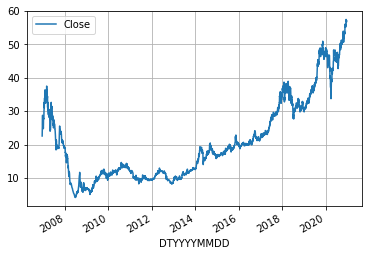

In [37]:
df.plot(grid=True)

#### Tính trung bình theo năm để thấy xu hướng chung

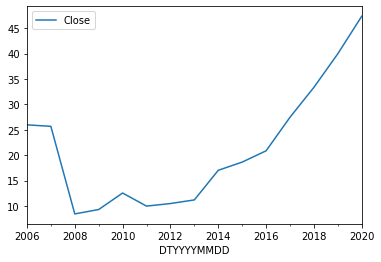

In [62]:
df.resample('Y').mean().plot()

- Nhận xét: Giá đóng cửa có xu hướng giảm và đạt nhỏ nhất vào năm 2008, tăng chậm trở lại trong giai đoạn từ 2010-2016, từ 2017 trở đi có xu hướng tăng, hiện tại đang đạt đỉnh

- Giải thích??

#### Xét giai đoạn gần đây: 2017 - nay

In [65]:
df_new = df.sort_index().loc['20170101':]

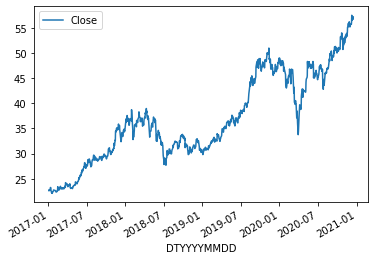

In [53]:
df_new.plot()

- Trending: Nhìn chung có xu hướng tăng, có 2 khoảng thời gian bị giảm bất thường là 07/2018-01/2019 và 01/2020-06/2020

- Giải thích???

#### Box plot

Text(0, 0.5, 'Close Prices')

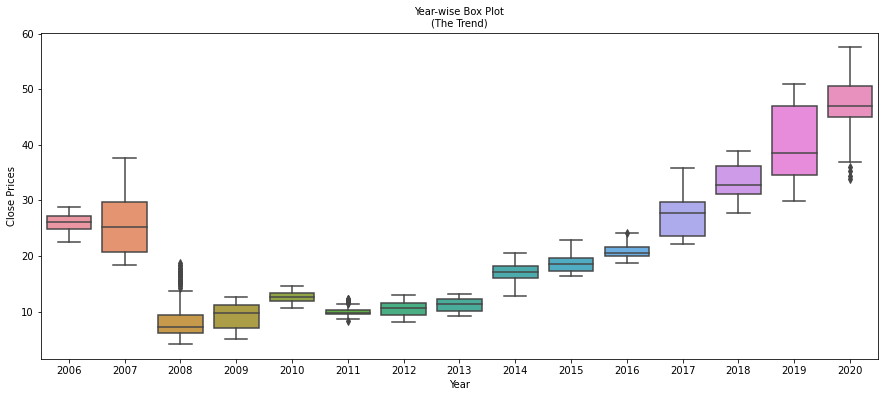

In [99]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.boxplot(df.index.year, df['Close'])
ax.set_title('Year-wise Box Plot\n(The Trend)', fontsize=10, loc='center')
ax.set_xlabel('Year')
ax.set_ylabel('Close Prices')



- Nhận xét: Các năm 2008, 2011, 2016, 2020 có các giá trị bất thường
    - 2008: Cao bất thường
    - 2011: Cao bất thường, thấp bất thường
    - 2016: Cao bất thường
    - 2020: Thấp bất thường

### Seasonal plot 

Mục đích: Tìm hiểu xem giá đóng cửa có bị ảnh hưởng bởi yếu tố mùa vụ (seasonal): tháng trong năm, ngày trong tháng, thứ trong tuần hay ko

#### Monthly box plot

Text(0, 0.5, 'Close Prices')

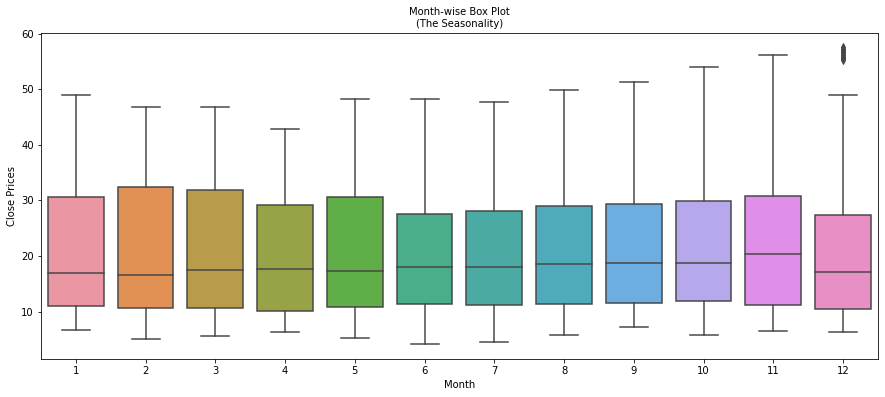

In [100]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.boxplot(df.index.month, df['Close'])
ax.set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=10, loc='center')
ax.set_xlabel('Month')
ax.set_ylabel('Close Prices')


Nhận xét: Giá đóng cửa có dấu hiệu cao bất thường vào tháng 12

#### Monthly seasonal line plot

In [132]:
years = sorted(set(df_monthly.index.year))
print(years)

[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [133]:
year_ranges = [[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014], [2015, 2016, 2017, 2018, 2019, 2020]]

monthly_dfs = [df[df.index.year.isin(i)].groupby(pd.Grouper(freq="M")).mean() for i in year_ranges]

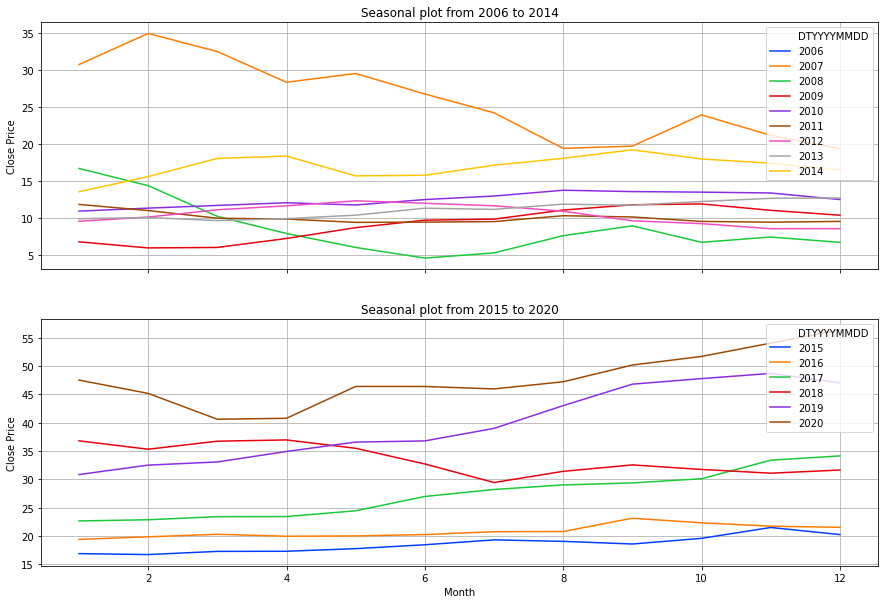

In [208]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

for i in range(2):
    sns.lineplot(monthly_dfs[i].index.month, monthly_dfs[i].Close, hue=monthly_dfs[i].index.year, palette='bright', ax=ax[i])
    ax[i].set_title(f'Seasonal plot from {year_ranges[i][0]} to {year_ranges[i][-1]}')
    ax[i].set_xlabel('Month')
    ax[i].set_ylabel('Close Price')
    ax[i].legend(loc='upper right')
    ax[i].grid()

- Nhận xét: 
    - Giai đoạn 2006 - 2014:
        - Năm 2007 & 2008: bất thường: cao ở đầu năm rồi giảm dần
        - Các năm còn lại có xu hướng ổn định
        
    - Giai đoạn 2015 - 2020:
        - 2015 & 2016: xu hướng ổn định
        - 2017 & 2019: xu hướng tăng dần về cuối năm
        - 2018: Cao ở giữa năm, giảm dần về cuối năm
        - 2020: Giảm ở đầu năm, tăng dần về cuối năm

### ETS 

In [148]:
import statsmodels.tsa.seasonal

In [158]:
df_monthly = df.groupby(pd.Grouper(freq="M")).mean()

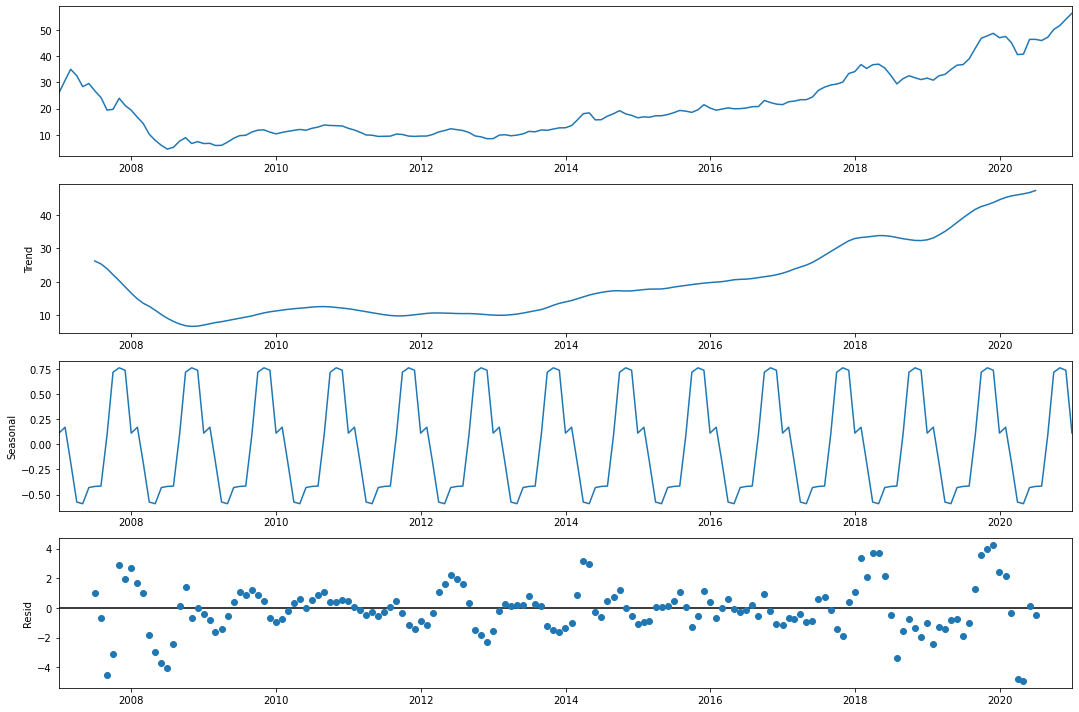

In [180]:
plt.rcParams["figure.figsize"] = (15, 10)

decomposition = statsmodels.tsa.seasonal.seasonal_decompose(df_monthly)
decomposition.plot()
plt.show()

- Giải thích???

## Stationary

- Most statistical forecasting methods are designed to work on a stationary time series. The first step in the forecasting process is typically to do some transformation to convert a non-stationary series to stationary. A stationary time series is one whose properties do not depend on the time at which the series is observed.



In [181]:
from statsmodels.tsa.stattools import adfuller


#### ADF test

In [183]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    result = adfuller(series.dropna(), autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [184]:
adf_test(df)

Augmented Dickey-Fuller Test: 
ADF test statistic        -2.781529
p-value                    0.060961
# lags used               23.000000
# observations          3466.000000
critical value (1%)       -3.432238
critical value (5%)       -2.862374
critical value (10%)      -2.567214
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


- Giải thích??

#### KPSS test

In [186]:
# KPSS Test
result = kpss(df, regression='c')
print("\nKPSS Statistic: {}".format(result[0]))
print("P-Value: {}".format(result[1]))
for key, value in result[3].items():
    print('Critial Values:')
    print("   {}, {}".format(key,value))



KPSS Statistic: 7.306358378140961
P-Value: 0.01
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\tuantv26\Anaconda3\envs\FundaPython\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\tuantv26\Anaconda3\envs\FundaPython\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


- Kết luận?
- Giải thích?

#### Granger Causality test

In [188]:
from statsmodels.tsa.stattools import grangercausalitytests

In [195]:
print(grangercausalitytests(data[['Close', 'Volume']], maxlag=2))



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7645  , p=0.0031  , df_denom=3486, df_num=1
ssr based chi2 test:   chi2=8.7720  , p=0.0031  , df=1
likelihood ratio test: chi2=8.7610  , p=0.0031  , df=1
parameter F test:         F=8.7645  , p=0.0031  , df_denom=3486, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5359  , p=0.0108  , df_denom=3483, df_num=2
ssr based chi2 test:   chi2=9.0848  , p=0.0106  , df=2
likelihood ratio test: chi2=9.0730  , p=0.0107  , df=2
parameter F test:         F=4.5359  , p=0.0108  , df_denom=3483, df_num=2
{1: ({'ssr_ftest': (8.764493082798404, 0.003092222536501997, 3486.0, 1), 'ssr_chi2test': (8.77203567581286, 0.0030588386917363495, 1), 'lrtest': (8.761026808429051, 0.0030773574318216524, 1), 'params_ftest': (8.764493942820584, 0.0030922210821053724, 3486.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000020CFE512340>, <statsmodels.regression.linear_m

- Giải thích?
- Kết luận?

## Autocorrelation plot

In [187]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [196]:
from pandas.plotting import lag_plot


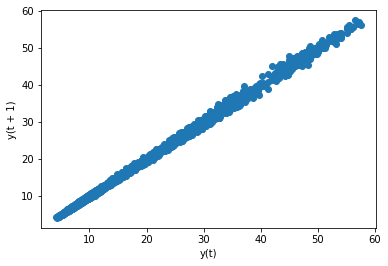

In [203]:
plt.rcParams["figure.figsize"] = (6, 4)

lag_plot(df, lag=1)

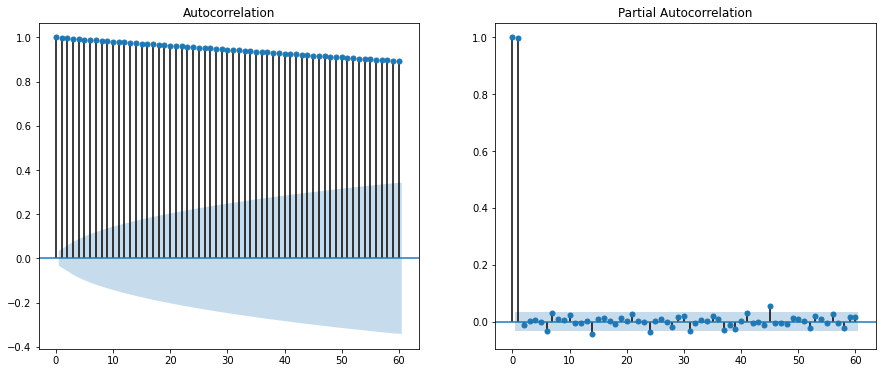

In [205]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
plot_acf(df, lags=60, ax=ax[0])
plot_pacf(df, lags=60, ax=ax[1])


In [206]:
from pandas.plotting import autocorrelation_plot


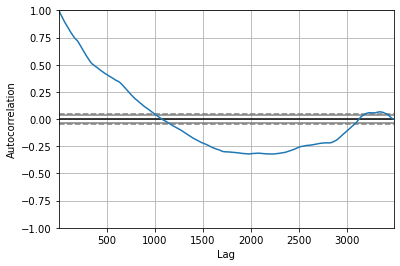

In [207]:
autocorrelation_plot(df)

- Giải thích?
- Kết luận?

## Moving Average

Moving average is the estimation of the trend-cycle at time t, and is obtained by averaging the values of the time series within k periods of t. Observations that are nearby in time are also likely to be close in value. Therefore, the average eliminates some of the randomness in the data, leaving a smooth trend-cycle component.

- The basic SMA has some weaknesses:
    - Smaller windows will lead to more noise, rather than signal.
    - It will always lag by the size of the window.
    - It will never reach the full peak or valley of the data due to the averaging.
    - It does not really inform you about possible future behavior, all it really does is describe trends in your data.
    - Extreme historical values can skew SMA significantly.


#### Simple Moving Average

In [218]:
df = df[['Close']]

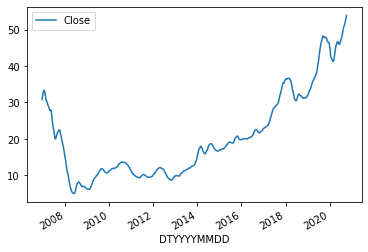

In [220]:
lag = 50
df.rolling(lag).mean().plot()

- Nhận xét?

#### EWMA

In [212]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


#### Double and Triple Exponential Smoothing

In [213]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


C:\Users\tuantv26\Anaconda3\envs\FundaPython\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\tuantv26\Anaconda3\envs\FundaPython\lib\site-packages\statsmodels\tsa\base\tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\tuantv26\Anaconda3\envs\FundaPython\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\tuantv26\Anaconda3\envs\FundaPython\lib\site-packages\statsmodels\tsa\base\tsa_model.py:220: ValueW

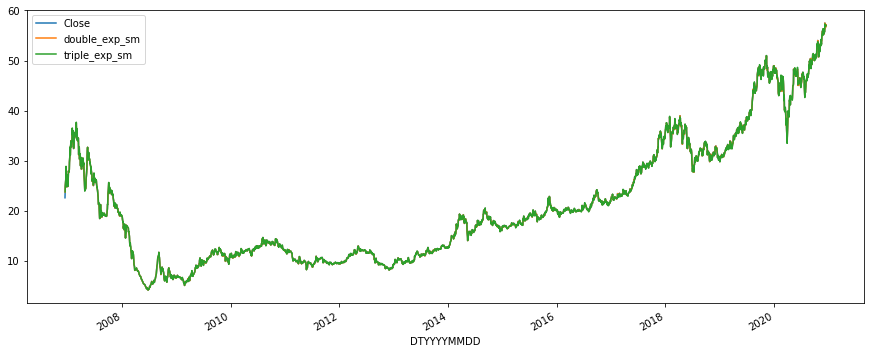

In [215]:
df['double_exp_sm'] = ExponentialSmoothing(df['Close'], trend='add').fit().fittedvalues.shift(-1)
df['triple_exp_sm'] = ExponentialSmoothing(df['Close'], trend='add',seasonal='add', seasonal_periods=12).fit().fittedvalues.shift(-1)
df[['Close', 'double_exp_sm', 'triple_exp_sm']].plot(figsize=(15,6))


Use 2019-2020 range

In [14]:
df = data[data.index.year.isin([2019, 2020])]


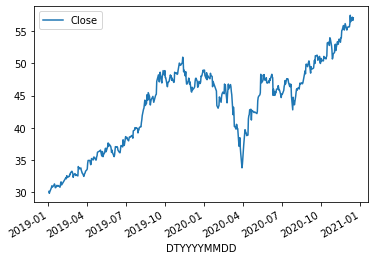

In [15]:
df[['Close']].plot()

Datetime processing

In [31]:
df = df.sort_index()
df.head()

,Open,High,Low,Close,Volume
DTYYYYMMDD,,,,,
2019-01-02,101.2,101.3,97.5,100.4,602450
2019-01-03,100.0,100.3,98.2,100.3,496950
2019-01-04,100.0,100.7,98.0,100.6,458000
2019-01-07,100.9,103.0,99.9,101.0,589150
2019-01-08,102.0,102.0,99.7,101.0,494300


In [32]:
df['date'] = df.index
# df['hour'] = df['date'].dt.hour
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofmonth'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.weekofyear
df.drop(columns=['date'], inplace=True)

Moving average

In [33]:
ma_day = [10, 20, 50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df[column_name] = df['Close'].rolling(ma).mean()


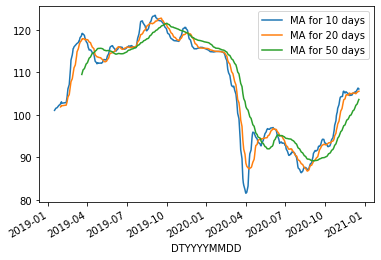

In [34]:
df[['MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()

Shifting values

In [35]:
cols = ['Open', 'High', 'Low', 'Close', 'Volume']

In [36]:
for col in cols:
    for i in range(1, 8):
        df[f'{col}_{i}'] = df[col].shift(i)

Set the High_Low limit

`lowerbound = 0.93 * Close_1`

`upperbound = 1.07 * Close_1`

In [37]:
df['lowerbound'] = 0.93 * df['Close_1']
df['upperbound'] = 1.07 * df['Close_1']

In [38]:
df.dropna(how='any', inplace=True)

In [39]:
df.tail()

,Open,High,Low,Close,Volume,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MA for 10 days,MA for 20 days,MA for 50 days,Open_1,Open_2,Open_3,Open_4,Open_5,Open_6,Open_7,High_1,High_2,High_3,High_4,High_5,High_6,High_7,Low_1,Low_2,Low_3,Low_4,Low_5,Low_6,Low_7,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Volume_1,Volume_2,Volume_3,Volume_4,Volume_5,Volume_6,Volume_7,lowerbound,upperbound
DTYYYYMMDD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-14,106.7,108.9,105.5,108.9,1122380,0,4,12,2020,349,14,51,105.90,105.315,102.548,104.9,106.0,105.0,105.8,106.0,105.8,105.0,106.8,107.0,106.0,105.8,106.0,106.5,105.8,104.9,104.9,104.4,104.8,105.1,104.5,104.3,106.8,104.9,106.0,105.0,105.8,105.8,105.8,569360.0,979550.0,789790.0,747280.0,678660.0,797060.0,731750.0,99.324,114.276
2020-12-15,108.9,108.9,106.7,107.0,1205700,1,4,12,2020,350,15,51,106.10,105.365,102.852,106.7,104.9,106.0,105.0,105.8,106.0,105.8,108.9,106.8,107.0,106.0,105.8,106.0,106.5,105.5,104.9,104.9,104.4,104.8,105.1,104.5,108.9,106.8,104.9,106.0,105.0,105.8,105.8,1122380.0,569360.0,979550.0,789790.0,747280.0,678660.0,797060.0,101.277,116.523
2020-12-16,106.8,107.1,105.9,107.0,756200,2,4,12,2020,351,16,51,106.30,105.470,103.142,108.9,106.7,104.9,106.0,105.0,105.8,106.0,108.9,108.9,106.8,107.0,106.0,105.8,106.0,106.7,105.5,104.9,104.9,104.4,104.8,105.1,107.0,108.9,106.8,104.9,106.0,105.0,105.8,1205700.0,1122380.0,569360.0,979550.0,789790.0,747280.0,678660.0,99.510,114.490
2020-12-17,107.0,107.0,104.6,104.7,1352580,3,4,12,2020,352,17,51,106.19,105.505,103.390,106.8,108.9,106.7,104.9,106.0,105.0,105.8,107.1,108.9,108.9,106.8,107.0,106.0,105.8,105.9,106.7,105.5,104.9,104.9,104.4,104.8,107.0,107.0,108.9,106.8,104.9,106.0,105.0,756200.0,1205700.0,1122380.0,569360.0,979550.0,789790.0,747280.0,99.510,114.490
2020-12-18,104.7,106.1,104.5,104.7,1350780,4,4,12,2020,353,18,51,106.08,105.550,103.612,107.0,106.8,108.9,106.7,104.9,106.0,105.0,107.0,107.1,108.9,108.9,106.8,107.0,106.0,104.6,105.9,106.7,105.5,104.9,104.9,104.4,104.7,107.0,107.0,108.9,106.8,104.9,106.0,1352580.0,756200.0,1205700.0,1122380.0,569360.0,979550.0,789790.0,97.371,112.029


Train test split

In [40]:
cols = [i for i in df.columns if i not in ['Open', 'High', 'Low', 'Volume']]
print(cols)

['Close', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days', 'Open_1', 'Open_2', 'Open_3', 'Open_4', 'Open_5', 'Open_6', 'Open_7', 'High_1', 'High_2', 'High_3', 'High_4', 'High_5', 'High_6', 'High_7', 'Low_1', 'Low_2', 'Low_3', 'Low_4', 'Low_5', 'Low_6', 'Low_7', 'Close_1', 'Close_2', 'Close_3', 'Close_4', 'Close_5', 'Close_6', 'Close_7', 'Volume_1', 'Volume_2', 'Volume_3', 'Volume_4', 'Volume_5', 'Volume_6', 'Volume_7', 'lowerbound', 'upperbound']


In [41]:
df = df[cols]
label_col = 'Close'

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
def get_data_splits(df, train_ratio: float, validation_ratio: float, test_ratio: float):
    train_len = int(df.shape[0] * train_ratio)
    train_data = df.iloc[: train_len]
    test_len = int(df.shape[0] * test_ratio)
    test_data = df.iloc[-test_len:]
    val_data = df.iloc[train_len:-test_len]
    return train_data, val_data, test_data

In [44]:
train_data, _, test_data = get_data_splits(df, train_ratio=0.5, validation_ratio=0, test_ratio=0.5)


In [45]:
train_data

,Close,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MA for 10 days,MA for 20 days,MA for 50 days,Open_1,Open_2,Open_3,Open_4,Open_5,Open_6,Open_7,High_1,High_2,High_3,High_4,High_5,High_6,High_7,Low_1,Low_2,Low_3,Low_4,Low_5,Low_6,Low_7,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Volume_1,Volume_2,Volume_3,Volume_4,Volume_5,Volume_6,Volume_7,lowerbound,upperbound
DTYYYYMMDD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-03-19,121.0,1,1,3,2019,78,19,12,118.92,117.705,109.496,120.0,119.3,116.5,118.5,119.0,117.0,119.0,121.3,119.3,118.8,120.0,119.4,118.3,119.6,119.1,117.9,115.6,117.0,118.2,117.0,118.1,121.3,118.7,118.8,117.5,118.6,118.3,118.1,1114570.0,1704580.0,1155340.0,1262350.0,902200.0,429390.0,845280.0,112.809,129.791
2019-03-20,120.2,2,1,3,2019,79,20,12,119.17,117.890,109.892,121.3,120.0,119.3,116.5,118.5,119.0,117.0,122.4,121.3,119.3,118.8,120.0,119.4,118.3,120.7,119.1,117.9,115.6,117.0,118.2,117.0,121.0,121.3,118.7,118.8,117.5,118.6,118.3,1190080.0,1114570.0,1704580.0,1155340.0,1262350.0,902200.0,429390.0,112.530,129.470
2019-03-21,117.0,3,1,3,2019,80,21,12,118.95,117.820,110.226,121.0,121.3,120.0,119.3,116.5,118.5,119.0,121.0,122.4,121.3,119.3,118.8,120.0,119.4,119.1,120.7,119.1,117.9,115.6,117.0,118.2,120.2,121.0,121.3,118.7,118.8,117.5,118.6,780190.0,1190080.0,1114570.0,1704580.0,1155340.0,1262350.0,902200.0,111.786,128.614
2019-03-22,118.6,4,1,3,2019,81,22,12,119.00,117.900,110.586,120.0,121.0,121.3,120.0,119.3,116.5,118.5,120.3,121.0,122.4,121.3,119.3,118.8,120.0,117.0,119.1,120.7,119.1,117.9,115.6,117.0,117.0,120.2,121.0,121.3,118.7,118.8,117.5,1208480.0,780190.0,1190080.0,1114570.0,1704580.0,1155340.0,1262350.0,108.810,125.190
2019-03-25,115.2,0,1,3,2019,84,25,13,118.69,117.845,110.870,117.0,120.0,121.0,121.3,120.0,119.3,116.5,118.9,120.3,121.0,122.4,121.3,119.3,118.8,117.0,117.0,119.1,120.7,119.1,117.9,115.6,118.6,117.0,120.2,121.0,121.3,118.7,118.8,1114660.0,1208480.0,780190.0,1190080.0,1114570.0,1704580.0,1155340.0,110.298,126.902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31,114.8,4,1,1,2020,31,31,5,114.92,114.885,115.524,114.1,114.9,114.3,114.9,114.9,115.0,115.0,114.9,114.9,115.0,114.9,115.1,115.1,115.0,112.1,114.2,114.3,114.3,114.4,114.3,114.3,114.9,114.9,114.9,114.9,114.9,115.0,115.0,682720.0,371780.0,181510.0,370670.0,169100.0,186740.0,205600.0,106.857,122.943
2020-02-03,114.8,0,1,2,2020,34,3,6,114.91,114.865,115.428,114.9,114.1,114.9,114.3,114.9,114.9,115.0,114.9,114.9,114.9,115.0,114.9,115.1,115.1,113.6,112.1,114.2,114.3,114.3,114.4,114.3,114.8,114.9,114.9,114.9,114.9,114.9,115.0,831740.0,682720.0,371780.0,181510.0,370670.0,169100.0,186740.0,106.764,122.836
2020-02-04,114.8,1,1,2,2020,35,4,6,114.89,114.855,115.362,113.8,114.9,114.1,114.9,114.3,114.9,114.9,114.8,114.9,114.9,114.9,115.0,114.9,115.1,112.3,113.6,112.1,114.2,114.3,114.3,114.4,114.8,114.8,114.9,114.9,114.9,114.9,114.9,760420.0,831740.0,682720.0,371780.0,181510.0,370670.0,169100.0,106.764,122.836


In [46]:
test_data

,Close,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MA for 10 days,MA for 20 days,MA for 50 days,Open_1,Open_2,Open_3,Open_4,Open_5,Open_6,Open_7,High_1,High_2,High_3,High_4,High_5,High_6,High_7,Low_1,Low_2,Low_3,Low_4,Low_5,Low_6,Low_7,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Volume_1,Volume_2,Volume_3,Volume_4,Volume_5,Volume_6,Volume_7,lowerbound,upperbound
DTYYYYMMDD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-07,114.4,4,1,2,2020,38,7,6,114.73,114.755,115.260,114.5,114.8,113.6,113.8,114.9,114.1,114.9,114.7,114.8,114.8,114.8,114.9,114.9,114.9,112.8,113.0,111.8,112.3,113.6,112.1,114.2,114.4,114.5,114.8,114.8,114.8,114.9,114.9,676290.0,468420.0,1485500.0,760420.0,831740.0,682720.0,371780.0,106.392,122.408
2020-02-10,113.7,0,1,2,2020,41,10,7,114.61,114.715,115.210,114.0,114.5,114.8,113.6,113.8,114.9,114.1,114.4,114.7,114.8,114.8,114.8,114.9,114.9,112.0,112.8,113.0,111.8,112.3,113.6,112.1,114.4,114.4,114.5,114.8,114.8,114.8,114.9,1295520.0,676290.0,468420.0,1485500.0,760420.0,831740.0,682720.0,106.392,122.408
2020-02-11,113.4,1,1,2,2020,42,11,7,114.46,114.650,115.158,113.0,114.0,114.5,114.8,113.6,113.8,114.9,114.1,114.4,114.7,114.8,114.8,114.8,114.9,113.0,112.0,112.8,113.0,111.8,112.3,113.6,113.7,114.4,114.4,114.5,114.8,114.8,114.8,192700.0,1295520.0,676290.0,468420.0,1485500.0,760420.0,831740.0,105.741,121.659
2020-02-12,112.0,2,1,2,2020,43,12,7,114.17,114.535,115.094,113.5,113.0,114.0,114.5,114.8,113.6,113.8,114.2,114.1,114.4,114.7,114.8,114.8,114.8,113.0,113.0,112.0,112.8,113.0,111.8,112.3,113.4,113.7,114.4,114.4,114.5,114.8,114.8,290630.0,192700.0,1295520.0,676290.0,468420.0,1485500.0,760420.0,105.462,121.338
2020-02-13,112.4,3,1,2,2020,44,13,7,113.92,114.420,115.030,113.4,113.5,113.0,114.0,114.5,114.8,113.6,113.4,114.2,114.1,114.4,114.7,114.8,114.8,112.0,113.0,113.0,112.0,112.8,113.0,111.8,112.0,113.4,113.7,114.4,114.4,114.5,114.8,452790.0,290630.0,192700.0,1295520.0,676290.0,468420.0,1485500.0,104.160,119.840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-14,108.9,0,4,12,2020,349,14,51,105.90,105.315,102.548,104.9,106.0,105.0,105.8,106.0,105.8,105.0,106.8,107.0,106.0,105.8,106.0,106.5,105.8,104.9,104.9,104.4,104.8,105.1,104.5,104.3,106.8,104.9,106.0,105.0,105.8,105.8,105.8,569360.0,979550.0,789790.0,747280.0,678660.0,797060.0,731750.0,99.324,114.276
2020-12-15,107.0,1,4,12,2020,350,15,51,106.10,105.365,102.852,106.7,104.9,106.0,105.0,105.8,106.0,105.8,108.9,106.8,107.0,106.0,105.8,106.0,106.5,105.5,104.9,104.9,104.4,104.8,105.1,104.5,108.9,106.8,104.9,106.0,105.0,105.8,105.8,1122380.0,569360.0,979550.0,789790.0,747280.0,678660.0,797060.0,101.277,116.523
2020-12-16,107.0,2,4,12,2020,351,16,51,106.30,105.470,103.142,108.9,106.7,104.9,106.0,105.0,105.8,106.0,108.9,108.9,106.8,107.0,106.0,105.8,106.0,106.7,105.5,104.9,104.9,104.4,104.8,105.1,107.0,108.9,106.8,104.9,106.0,105.0,105.8,1205700.0,1122380.0,569360.0,979550.0,789790.0,747280.0,678660.0,99.510,114.490


In [47]:
X_train, y_train = train_data.drop(columns=[label_col]), train_data[label_col]
X_test, y_test = test_data.drop(columns=[label_col]), test_data[label_col]

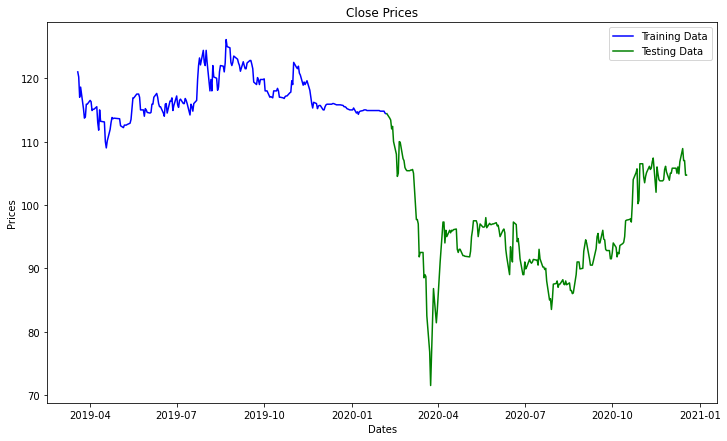

In [48]:
plt.figure(figsize=(12,7))
plt.title('Close Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(y_train, 'blue', label='Training Data')
plt.plot(y_test, 'green', label='Testing Data')
plt.legend()


## Baseline

Linear Regression

In [49]:
from sklearn.linear_model import LinearRegression

In [50]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

Evaluate

In [51]:
from sklearn.metrics import mean_squared_error, r2_score

In [52]:
def MAPE(y_true, y_pred):
    error = np.abs(y_true - y_pred) / y_true
    error.replace([np.inf, -np.inf], np.nan, inplace=True)
    error = error[~np.isnan(error)]

    return np.mean(error) * 100


In [53]:
y_pred = linear_reg.predict(X_test)
y_pred = pd.Series(y_pred, index=y_test.index)
MAPE(y_test, y_pred)

1.854000752016945

In [54]:
mean_squared_error(y_test, y_pred)

5.3571721126255865

In [55]:
r2_score(y_test, y_pred)

0.9054957526101425

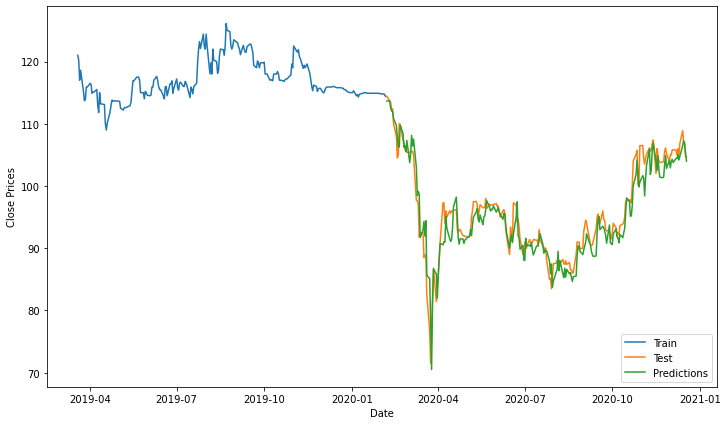

In [56]:
plt.figure(figsize=(12, 7))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(y_train)
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()